# Environment

kaggle link :https://www.kaggle.com/trnhuy2107/test-resnetv2-error-case

* 

* [LOAD MODEL](#h1)
* [SHOW RESULT](#h2)


 ## LOAD MODEL  <a class="anchor"  id="h1"></a>

In [1]:
import os
import math

import numpy as np
import pandas as pd



from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

### Data loading

In [2]:
!pip install gdown
!gdown 1HupS43P60W1vzBxEvNMmKJubum9QqY_r

Downloading...
From (uriginal): https://drive.google.com/uc?id=1HupS43P60W1vzBxEvNMmKJubum9QqY_r
From (redirected): https://drive.google.com/uc?id=1HupS43P60W1vzBxEvNMmKJubum9QqY_r&confirm=t&uuid=4a384da7-6d7e-429a-b705-a5be87fbec5e
To: /kaggle/working/data_v2.zip
100%|████████████████████████████████████████| 370M/370M [00:05<00:00, 64.1MB/s]


In [3]:
# load data lớn
!unzip -q  /kaggle/working/data_v2.zip

warning [/kaggle/working/data_v2.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [/kaggle/working/data_v2.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
error:  expected central file header signature not found (file #113063).
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)


In [4]:
# Path to the data directory
data_dir = Path("./data_v2/")#("./captcha_images_v2/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.jpg")))))
labels = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in images]
characters = set(char for label in labels for char in label)#Set trong Python là tập hợp các phần tử duy nhất, không có thứ tự
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 512

# Desired image dimensions
img_width = 200
img_height = 50

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

Number of images found:  113062
Number of labels found:  113062
Number of unique characters:  60
Characters present:  ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


### Preprocessing

In [5]:
X_train,X_val_test,y_train,y_val_test=train_test_split(images,labels,test_size=0.2,random_state=2023)
X_val,X_test,y_val,y_test=train_test_split(X_val_test,y_val_test,test_size=0.5,random_state=2023)

x_train=np.array(X_train)
x_val=np.array(X_val)
x_test=np.array(X_test)

y_train=np.array(y_train)
y_val=np.array(y_val)
y_test=np.array(y_test)

In [6]:
# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)



def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    #print(img)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=3)#channels=1 để chuyển sang thang độ xám, để 3 nếu muốn nahr màu


    #print(img)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    #print(img)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    #print(img.shape)
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])# chuyển vị matrix hàng thành cột và cột thành hàng
    #print(img.shape)
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}


### Create `Dataset` objects

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = (
    test_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

### Evaluation

In [20]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [10]:
!pip install gdown
!gdown 1TLZUDN8dGv0qIhYzHqzcfIkV4HClR8ms
!unzip -q "/kaggle/working/model (1).zip"
model= tf.keras.saving.load_model("/kaggle/working/kaggle/working/resnet50v2")

Downloading...
From: https://drive.google.com/uc?id=1TLZUDN8dGv0qIhYzHqzcfIkV4HClR8ms
To: /kaggle/working/model (1).zip
100%|███████████████████████████████████████| 2.77M/2.77M [00:00<00:00, 110MB/s]


In [11]:
model= tf.keras.saving.load_model("/kaggle/working/kaggle/working/resnet50v2")

### Vali set

In [13]:
pred = model.predict(validation_dataset)

23/23 [==============================] - 3s 139ms/step


In [14]:
pred_texts = decode_batch_predictions(pred)
print(pred_texts[0:5])
print(y_val[0:5])
y_true = y_val
correct_char = 0
total_char = 0
correct = 0
#xét từng cặp true,pred
# nếu true=pred thì số nhãn đoán đúng +1
# với mỗi kí tự trong true ss với kí tự trong pred ở vị trí tương ứng, nếu bằng số kí tự đúng +1
for i in range(len(y_true)):
    pr = pred_texts[i]
    tr = y_true[i]
    total_char += len(tr)
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1

    if pr == tr :
        correct += 1

print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))#nếu muốn tính % sai hãy dùng Edit distance
print('Correct words predicted      : %.2f%%' %(correct*100/len(y_true)))

['wGC8A', 'pJlha', 'AlgsR', 'geqBS', 'EFXCl']
['wGC8A' 'pJlha' 'AlgsR' 'geqBS' 'EFXCl']
Correct characters predicted : 89.32%
Correct words predicted      : 70.26%


### Test set

In [15]:
preds = model.predict(test_dataset)

pred_texts = decode_batch_predictions(preds)
print(pred_texts[0:5])
print(y_test[0:5])
y_true = y_test
correct_char = 0
total_char = 0
correct = 0
#xét từng cặp true,pred
# nếu true=pred thì số nhãn đoán đúng +1
# với mỗi kí tự trong true ss với kí tự trong pred ở vị trí tương ứng, nếu bằng số kí tự đúng +1
for i in range(len(y_true)):
    pr = pred_texts[i]
    tr = y_true[i]
    total_char += len(tr)
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1

    if pr == tr :
        correct += 1

print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))#nếu muốn tính % sai hãy dùng Edit distance
print('Correct words predicted      : %.2f%%' %(correct*100/len(y_true)))

23/23 [==============================] - 4s 151ms/step
['SZqp9', 'JUN5z', 'LwdcR', 'QIbyv', 'BZ5SZ']
['SZqp9' 'JUN5z' 'LwDcR' 'Qlbyv' 'BZ5SZ']
Correct characters predicted : 89.04%
Correct words predicted      : 69.57%


# Inference

## Validation Set

In [16]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 3)]      0         
                                                                 
 model (Functional)          (None, 50, 13, 64)        173568    
                                                                 
 reshape (Reshape)           (None, 50, 832)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            53312     
                                                                 
 dropout_3 (Dropout)         (None, 50, 64)            0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 50, 256)          197632    
 nal)                                                            
                                                             

 ## DEMO RESULT  <a class="anchor"  id="h2"></a>

WRONG CASE

(512, 200, 50, 3)
(512, 5)
16/16 [==============================] - 2s 16ms/step
(512, 50, 62)


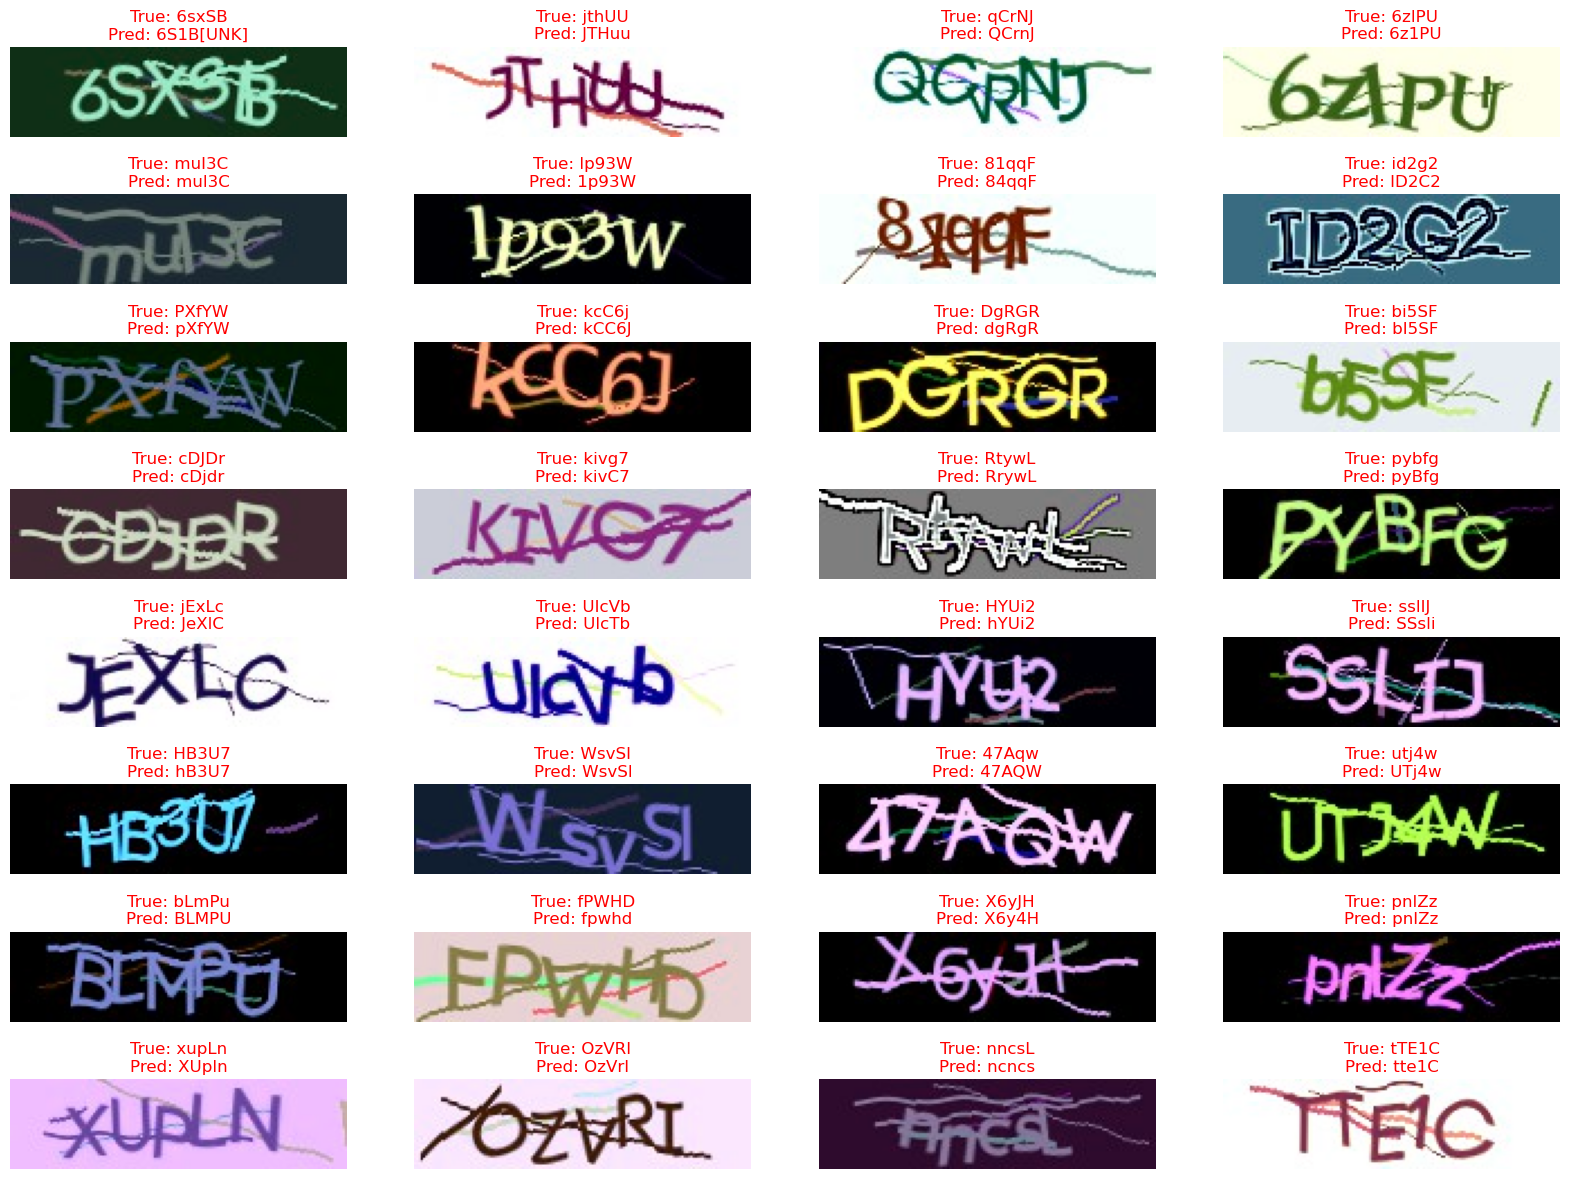

In [17]:
#HERRRRRRRRRREEEEEEEEEEEEEEEEEEEEEEEE
#đang show hết các trường hợp sai
#start i
i=180
import cv2
#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]
    print(batch_images.shape)
    print(batch_labels.shape)
    preds = model.predict(batch_images)
    print(preds.shape)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(8,4, figsize=(20, 15))# 4 hàng , 4 cột
    
    j=0
    while True:
        pred_label=pred_texts[i]
        true_label=orig_texts[i]
        if true_label == pred_label:
                i=i+1
                continue
                j=j+1
                title_color = 'green'
        else:
                i=i+1
                j=j+1
                title_color = 'red'
                
        if j<=32:# chỗ này có 16 ô để vẽ hình thôi nên để i>16 tức là vẽ nhiều hơn 16 hình thì lỗi
            #img = #(batch_images[i, :, :, :] * 255).numpy().astype(np.uint8)
            img = cv2.imread("/kaggle/working/data_v2/"+true_label+".jpg")
            #title = f"Prediction: {pred_texts[i]}"
            temp=j-1
            ax[temp// 4, temp % 4].imshow(img)
            ax[temp// 4, temp % 4].set_title('True: '+true_label+'\nPred: '+pred_label,color=title_color)
            ax[temp// 4, temp % 4].axis("off")
        else:
            break
        
plt.show()

ALL CASE

(512, 200, 50, 3)
(512, 5)
16/16 [==============================] - 0s 11ms/step
(512, 50, 62)


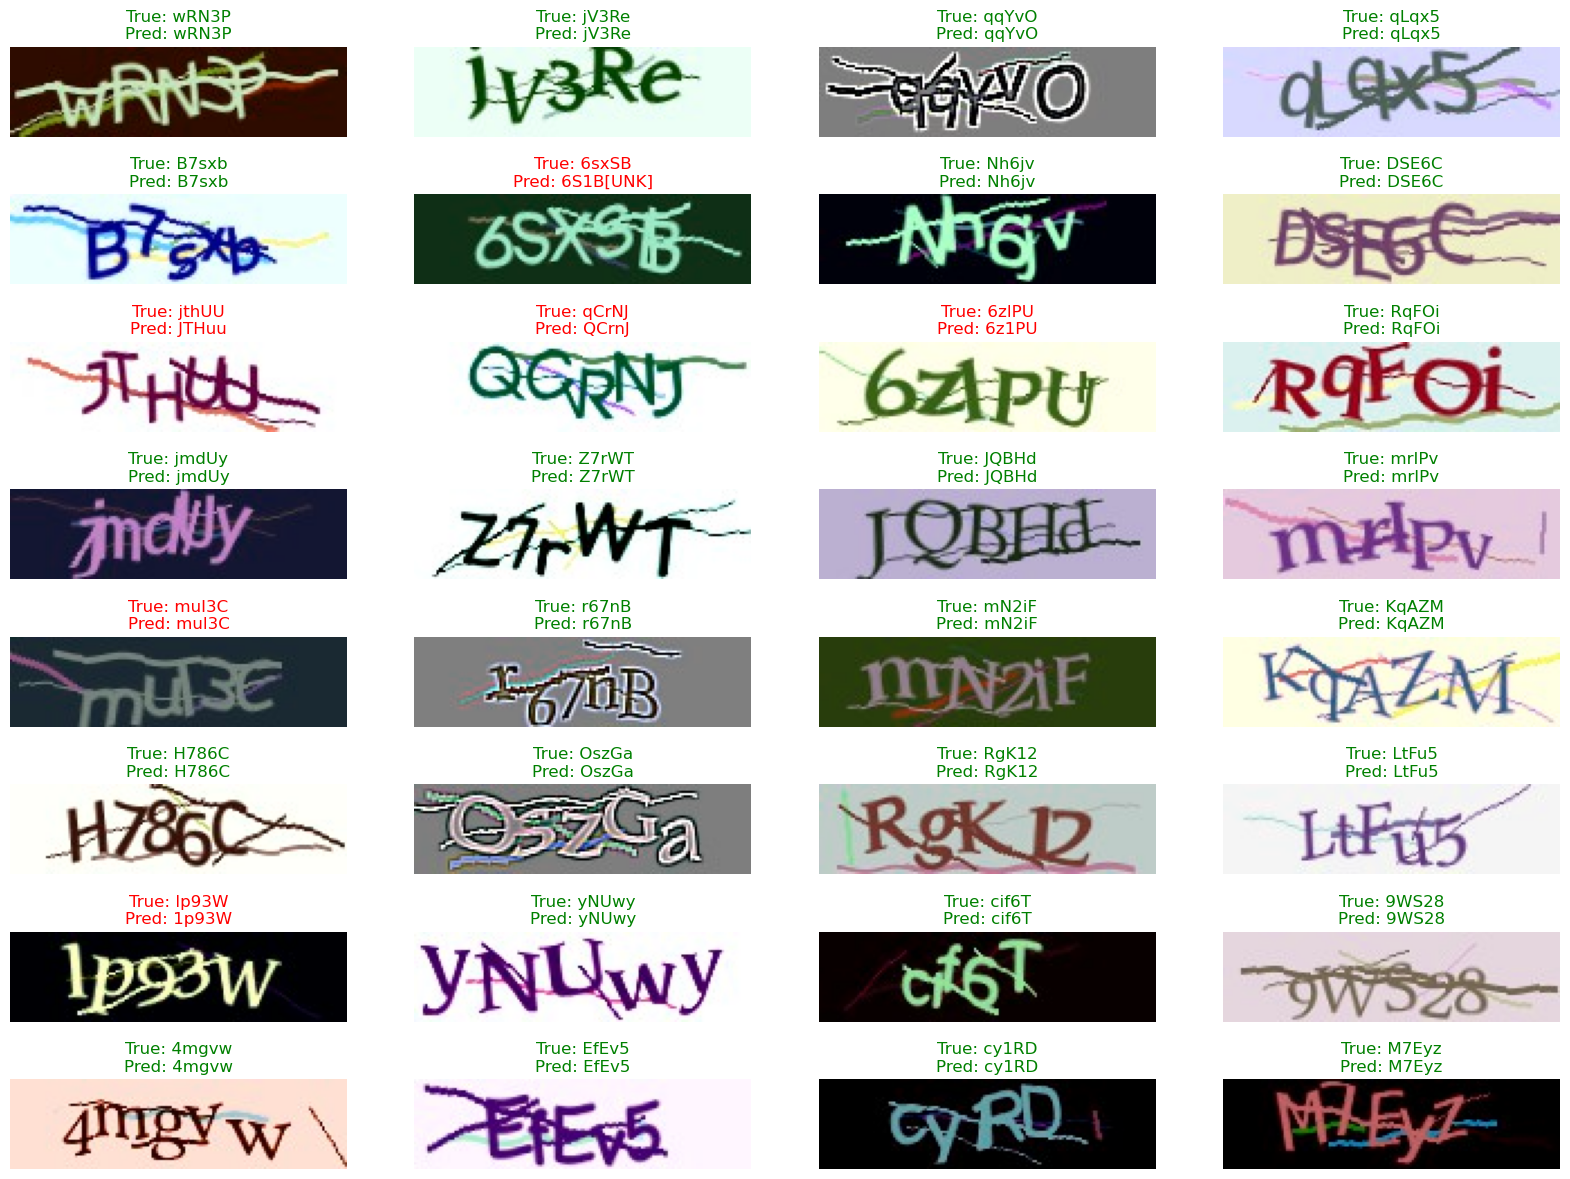

In [18]:
#HERRRRRRRRRR\EEEEEEEEEEEEEEEEEEEEEEEE
#đang show các trường hợp
#start i
i=180
import cv2
#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]
    print(batch_images.shape)
    print(batch_labels.shape)
    preds = model.predict(batch_images)
    print(preds.shape)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(8,4, figsize=(20, 15))# 4 hàng , 4 cột
    
    j=0
    while True:
        pred_label=pred_texts[i]
        true_label=orig_texts[i]
        if true_label == pred_label:
                i=i+1
                j=j+1
                title_color = 'green'
        else:
                i=i+1
                j=j+1
                title_color = 'red'
                
        if j<=32:# chỗ này có 16 ô để vẽ hình thôi nên để i>16 tức là vẽ nhiều hơn 16 hình thì lỗi
            #img = #(batch_images[i, :, :, :] * 255).numpy().astype(np.uint8)
            img = cv2.imread("/kaggle/working/data_v2/"+true_label+".jpg")
            #title = f"Prediction: {pred_texts[i]}"
            temp=j-1
            ax[temp// 4, temp % 4].imshow(img)
            ax[temp// 4, temp % 4].set_title('True: '+true_label+'\nPred: '+pred_label,color=title_color)
            ax[temp// 4, temp % 4].axis("off")
        else:
            break
        
plt.show()

CORRECT CASE

(512, 200, 50, 3)
(512, 5)
16/16 [==============================] - 0s 12ms/step
(512, 50, 62)


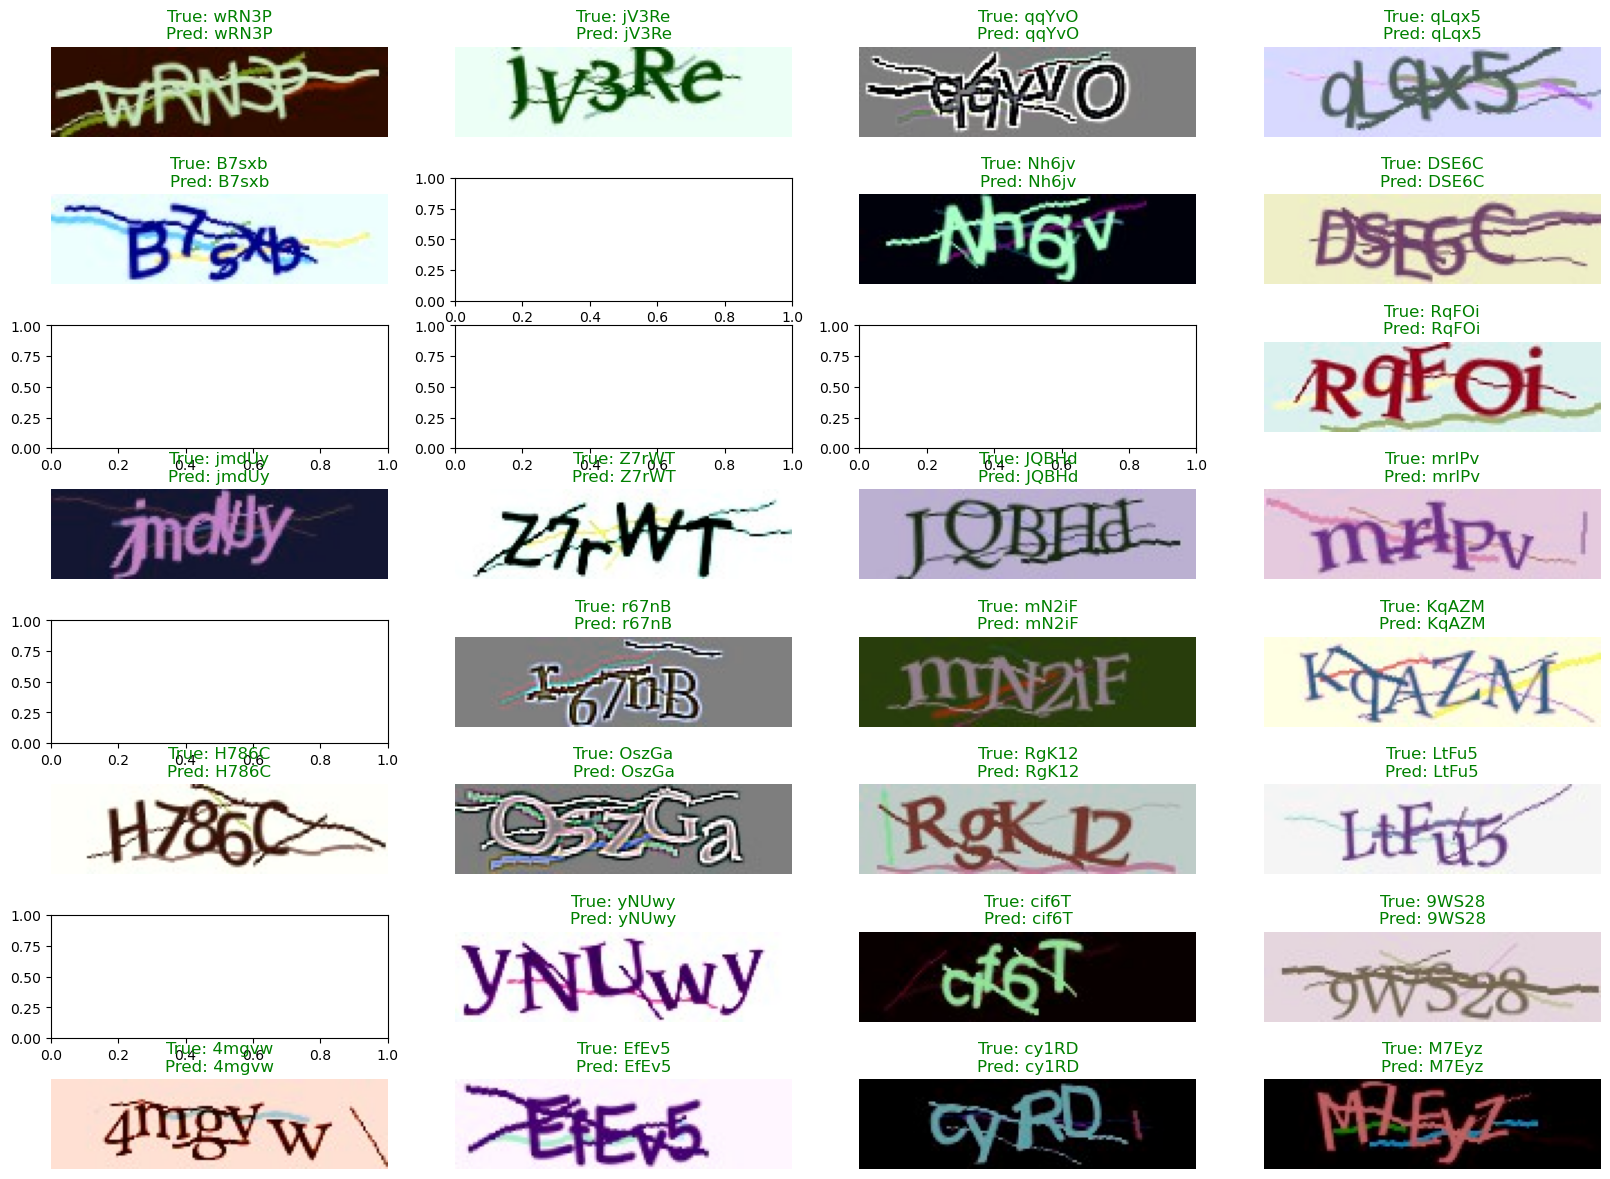

In [19]:
#HERRRRRRRRRR\EEEEEEEEEEEEEEEEEEEEEEEE
#đang show các trường hợp đúng
#start i
i=180
import cv2
#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]
    print(batch_images.shape)
    print(batch_labels.shape)
    preds = model.predict(batch_images)
    print(preds.shape)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(8,4, figsize=(20, 15))# 4 hàng , 4 cột
    
    j=0
    while True:
        pred_label=pred_texts[i]
        true_label=orig_texts[i]
        if true_label == pred_label:
                i=i+1
                j=j+1
                title_color = 'green'
        else:
                i=i+1
                j=j+1
                continue
                title_color = 'red'
                
        if j<=32:# chỗ này có 16 ô để vẽ hình thôi nên để i>16 tức là vẽ nhiều hơn 16 hình thì lỗi
            #img = #(batch_images[i, :, :, :] * 255).numpy().astype(np.uint8)
            img = cv2.imread("/kaggle/working/data_v2/"+true_label+".jpg")
            #title = f"Prediction: {pred_texts[i]}"
            temp=j-1
            ax[temp// 4, temp % 4].imshow(img)
            ax[temp// 4, temp % 4].set_title('True: '+true_label+'\nPred: '+pred_label,color=title_color)
            ax[temp// 4, temp % 4].axis("off")
        else:
            break
        
plt.show()

## Test Set

#Save model

#Load Model & Test Set Evaluation